## 1. 📦 Imports et Configuration

In [43]:
# Imports standards
import pandas as pd
import numpy as np
import pickle
import os
import warnings
from datetime import datetime
import time

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Machine Learning - Modèles classiques
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# Machine Learning - Évaluation
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay
)

# Transformers (TunBERT)
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from datasets import Dataset
from sklearn.metrics import precision_recall_fscore_support

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✅ Tous les packages importés avec succès!")
print(f"📅 Date d'exécution: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🔧 PyTorch version: {torch.__version__}")
print(f"🎮 CUDA disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")

✅ Tous les packages importés avec succès!
📅 Date d'exécution: 2025-12-14 14:39:08
🔧 PyTorch version: 2.8.0+cu128
🎮 CUDA disponible: True
🎮 GPU: NVIDIA GeForce RTX 3050 Laptop GPU


## 2. 📁 Chargement des Données Preprocessées

In [44]:
# Définir le chemin vers les artefacts
PROCESSOR_DIR = '../processors'
MODELS_DIR = '../models'

# Créer le dossier models
os.makedirs(MODELS_DIR, exist_ok=True)

print(f"📁 Dossier processors: {PROCESSOR_DIR}")
print(f"📁 Dossier models: {MODELS_DIR}")

📁 Dossier processors: ../processors
📁 Dossier models: ../models


In [45]:
# Charger les données preprocessées
print("\n📦 Chargement des données preprocessées...")
print("="*80)

with open(os.path.join(PROCESSOR_DIR, 'preprocessed_data.pkl'), 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']

print("✅ Données chargées avec succès!")
print(f"   • Train: {X_train.shape}")
print(f"   • Val:   {X_val.shape}")
print(f"   • Test:  {X_test.shape}")


📦 Chargement des données preprocessées...
✅ Données chargées avec succès!
   • Train: (2403, 942)
   • Val:   (515, 942)
   • Test:  (516, 942)


In [46]:
# Charger le vectorizer pour usage futur
with open(os.path.join(PROCESSOR_DIR, 'tfidf_vectorizer.pkl'), 'rb') as f:
    vectorizer = pickle.load(f)

print("✅ Vectorizer TF-IDF chargé!")
print(f"   • Vocabulaire: {len(vectorizer.get_feature_names_out())} mots")

✅ Vectorizer TF-IDF chargé!
   • Vocabulaire: 942 mots


## 3. 🤖 Modèles ML Classiques (TF-IDF)

### 3.1. Initialisation et Entraînement

In [47]:
print("\n🤖 ENTRAÎNEMENT DES MODÈLES ML CLASSIQUES")
print("="*80)

# Initialisation des modèles
models = {
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(
        hidden_layer_sizes=(10, 10),
        activation='logistic',
        solver='adam',
        max_iter=500,
        random_state=42
    ),
    'SVM Linear': SVC(kernel='linear', random_state=42),
    'SVM RBF': SVC(kernel='rbf', random_state=42),
    'SVM Sigmoid': SVC(kernel='sigmoid', random_state=42),
    'SVM Poly': SVC(kernel='poly', degree=2, random_state=42)
}

# Dictionnaires pour stocker résultats
trained_models = {}
predictions = {}
training_times = {}

print(f"📋 {len(models)} modèles initialisés")


🤖 ENTRAÎNEMENT DES MODÈLES ML CLASSIQUES
📋 6 modèles initialisés


In [48]:
# Entraînement des modèles
for name, model in models.items():
    print(f"\n🔄 Entraînement: {name}...")
    start_time = time.time()
    
    # Fit
    model.fit(X_train, y_train)
    
    # Prédiction
    y_pred = model.predict(X_test)
    
    # Stocker
    trained_models[name] = model
    predictions[name] = y_pred
    training_times[name] = time.time() - start_time
    
    print(f"   ✅ Terminé en {training_times[name]:.2f}s")

print("\n✅ Tous les modèles ML classiques entraînés!")


🔄 Entraînement: Naive Bayes...
   ✅ Terminé en 0.03s

🔄 Entraînement: Neural Network...
   ✅ Terminé en 9.91s

🔄 Entraînement: SVM Linear...
   ✅ Terminé en 1.41s

🔄 Entraînement: SVM RBF...
   ✅ Terminé en 2.15s

🔄 Entraînement: SVM Sigmoid...
   ✅ Terminé en 1.64s

🔄 Entraînement: SVM Poly...
   ✅ Terminé en 2.15s

✅ Tous les modèles ML classiques entraînés!


### 3.2. Évaluation des Modèles ML

In [49]:
# Évaluation détaillée
print("\n📊 ÉVALUATION DES MODÈLES ML CLASSIQUES")
print("="*80)

results_ml = []

for name, y_pred in predictions.items():
    print(f"\n{'='*80}")
    print(f"📈 {name}")
    print(f"{'='*80}")
    
    # Métriques
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='binary')
    rec = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    
    print(f"\n   Accuracy:  {acc:.4f}")
    print(f"   Precision: {prec:.4f}")
    print(f"   Recall:    {rec:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    print(f"   Training Time: {training_times[name]:.2f}s")
    
    # Classification report
    print(f"\n   Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Classe 0', 'Classe 1'], digits=4))
    
    # Stocker résultats
    results_ml.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'Training Time (s)': training_times[name]
    })


📊 ÉVALUATION DES MODÈLES ML CLASSIQUES

📈 Naive Bayes

   Accuracy:  0.7016
   Precision: 0.6887
   Recall:    0.7052
   F1-Score:  0.6969
   Training Time: 0.03s

   Classification Report:
              precision    recall  f1-score   support

    Classe 0     0.7143    0.6981    0.7061       265
    Classe 1     0.6887    0.7052    0.6969       251

    accuracy                         0.7016       516
   macro avg     0.7015    0.7016    0.7015       516
weighted avg     0.7018    0.7016    0.7016       516


📈 Neural Network

   Accuracy:  0.7267
   Precision: 0.7115
   Recall:    0.7371
   F1-Score:  0.7241
   Training Time: 9.91s

   Classification Report:
              precision    recall  f1-score   support

    Classe 0     0.7422    0.7170    0.7294       265
    Classe 1     0.7115    0.7371    0.7241       251

    accuracy                         0.7267       516
   macro avg     0.7269    0.7270    0.7267       516
weighted avg     0.7273    0.7267    0.7268       516




In [50]:
# Tableau comparatif
df_results_ml = pd.DataFrame(results_ml)
df_results_ml = df_results_ml.sort_values('F1-Score', ascending=False)

print("\n📊 TABLEAU COMPARATIF DES MODÈLES ML")
print("="*80)
print(df_results_ml.to_string(index=False))

# Meilleur modèle ML
best_ml = df_results_ml.iloc[0]
print(f"\n🏆 Meilleur modèle ML: {best_ml['Model']} (F1={best_ml['F1-Score']:.4f})")


📊 TABLEAU COMPARATIF DES MODÈLES ML
         Model  Accuracy  Precision   Recall  F1-Score  Training Time (s)
Neural Network  0.726744   0.711538 0.737052  0.724070           9.909503
    SVM Linear  0.744186   0.771689 0.673307  0.719149           1.409311
      SVM Poly  0.750000   0.796117 0.653386  0.717724           2.150894
       SVM RBF  0.740310   0.774648 0.657371  0.711207           2.148856
   SVM Sigmoid  0.734496   0.766355 0.653386  0.705376           1.644220
   Naive Bayes  0.701550   0.688716 0.705179  0.696850           0.034632

🏆 Meilleur modèle ML: Neural Network (F1=0.7241)


### 3.3. Sauvegarde des Modèles ML

In [51]:
# Sauvegarder tous les modèles ML
print("\n💾 Sauvegarde des modèles ML...")

for name, model in trained_models.items():
    # Créer un nom de fichier safe
    filename = name.lower().replace(' ', '_').replace('-', '_')
    filepath = os.path.join(MODELS_DIR, f'model_{filename}.pkl')
    
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    
    print(f"   ✅ {name} → {filename}.pkl")

# Sauvegarder le vectorizer
with open(os.path.join(MODELS_DIR, 'tfidf_vectorizer.pkl'), 'wb') as f:
    pickle.dump(vectorizer, f)
print(f"   ✅ TF-IDF Vectorizer → tfidf_vectorizer.pkl")

print("\n✅ Tous les modèles ML sauvegardés dans:", MODELS_DIR)


💾 Sauvegarde des modèles ML...
   ✅ Naive Bayes → naive_bayes.pkl
   ✅ Neural Network → neural_network.pkl
   ✅ SVM Linear → svm_linear.pkl
   ✅ SVM RBF → svm_rbf.pkl
   ✅ SVM Sigmoid → svm_sigmoid.pkl
   ✅ SVM Poly → svm_poly.pkl
   ✅ TF-IDF Vectorizer → tfidf_vectorizer.pkl

✅ Tous les modèles ML sauvegardés dans: ../models


## 4. 🚀 Fine-tuning TunBERT (Transformer)

### 4.1. Chargement des Données Textuelles

In [52]:
# Charger les textes nettoyés
print("\n📦 Chargement des textes pour TunBERT...")
with open(os.path.join(PROCESSOR_DIR, 'cleaned_texts.pkl'), 'rb') as f:
    texts_data = pickle.load(f)

comments = texts_data['cleaned']
labels = texts_data['labels']

print(f"✅ Textes chargés: {len(comments)} commentaires")


📦 Chargement des textes pour TunBERT...
✅ Textes chargés: 3434 commentaires


In [53]:
# Créer DataFrame et split stratifié
from sklearn.model_selection import train_test_split

df_bert = pd.DataFrame({
    'comments': comments,
    'target': labels
})

# Split 70-15-15
train_df, temp_df = train_test_split(
    df_bert, 
    test_size=0.3, 
    random_state=42, 
    stratify=df_bert['target']
)
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    random_state=42, 
    stratify=temp_df['target']
)

print(f"\n✅ Split pour TunBERT:")
print(f"   Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")


✅ Split pour TunBERT:
   Train: 2403 | Val: 515 | Test: 516


In [54]:
# Créer datasets HuggingFace
train_dataset = Dataset.from_pandas(train_df[['comments', 'target']])
val_dataset = Dataset.from_pandas(val_df[['comments', 'target']])
test_dataset = Dataset.from_pandas(test_df[['comments', 'target']])

print("✅ Datasets HuggingFace créés!")

✅ Datasets HuggingFace créés!


### 4.2. Chargement du Modèle TunBERT

In [56]:
# Charger TunBERT tokenizer et modèle
print("\n🔄 Chargement de TunBERT...")
device = torch.device("cuda:0") # 🔥 Envoie le modèle sur la GPU
print(f"Modèle chargé sur : {device}")
model_name = "tunis-ai/TunBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    trust_remote_code=True,
    num_labels=2
)
model.to(device)
print(f"✅ TunBERT chargé: {model_name}")
print(f"   • Paramètres: {sum(p.numel() for p in model.parameters()):,}")


🔄 Chargement de TunBERT...
Modèle chargé sur : cuda:0
✅ TunBERT chargé: tunis-ai/TunBERT
   • Paramètres: 110,074,370


### 4.3. Tokenization

In [57]:
# Fonction de tokenization
def tokenize_function(examples):
    return tokenizer(
        examples['comments'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

# Appliquer tokenization
print("\n🔄 Tokenization des datasets...")
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

print("✅ Tokenization terminée!")


🔄 Tokenization des datasets...


Map:   0%|          | 0/2403 [00:00<?, ? examples/s]

Map:   0%|          | 0/515 [00:00<?, ? examples/s]

Map:   0%|          | 0/516 [00:00<?, ? examples/s]

✅ Tokenization terminée!


In [58]:
# Renommer colonne target -> labels
train_dataset = train_dataset.rename_column("target", "labels")
val_dataset = val_dataset.rename_column("target", "labels")
test_dataset = test_dataset.rename_column("target", "labels")

# Format PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

print("✅ Datasets formatés pour PyTorch!")

✅ Datasets formatés pour PyTorch!


### 4.4. Configuration et Entraînement

In [69]:
# Fonction de métriques
def compute_metrics(pred):
    labels = pred.label_ids
    predictions = pred.predictions[0] if isinstance(pred.predictions, tuple) else pred.predictions
    preds = predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary'
    )
    acc = accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

print("✅ Fonction de métriques définie!")

✅ Fonction de métriques définie!


In [70]:
# Configuration de l'entraînement
training_args = TrainingArguments(
    output_dir="../tunbert_finetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=6,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="../logs",
    logging_steps=50,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    report_to="none"
)

print("✅ Arguments d'entraînement configurés!")
print(f"   • Epochs: {training_args.num_train_epochs}")
print(f"   • Batch size: {training_args.per_device_train_batch_size}")
print(f"   • Learning rate: {training_args.learning_rate}")
print(f"   • FP16 (mixed precision): {training_args.fp16}")

✅ Arguments d'entraînement configurés!
   • Epochs: 6
   • Batch size: 8
   • Learning rate: 2e-05
   • FP16 (mixed precision): True


In [71]:
# Créer Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

print("✅ Trainer initialisé!")

✅ Trainer initialisé!


In [72]:
# Entraînement TunBERT
print("\n🚀 DÉBUT DE L'ENTRAÎNEMENT TUNBERT")
print("="*80)
print("⏳ Cela peut prendre plusieurs minutes...\n")

train_result = trainer.train()

print("\n✅ Entraînement TunBERT terminé!")
print(f"   • Training loss: {train_result.training_loss:.4f}")


🚀 DÉBUT DE L'ENTRAÎNEMENT TUNBERT
⏳ Cela peut prendre plusieurs minutes...



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.557500,0.594375,0.724272,0.663507,0.818713,0.557769
2,0.459500,0.429489,0.809709,0.783186,0.880597,0.705179
3,0.421800,0.432919,0.807767,0.817006,0.762069,0.880478
4,0.363800,0.594335,0.815534,0.822430,0.774648,0.876494
5,0.280800,0.600235,0.823301,0.826667,0.791971,0.864542
6,0.257100,0.637067,0.836893,0.835294,0.822394,0.848606



✅ Entraînement TunBERT terminé!
   • Training loss: 0.3769


### 4.5. Évaluation TunBERT

In [73]:
# Évaluation sur l'ensemble de test
print("\n📊 ÉVALUATION TUNBERT SUR TEST SET")
print("="*80)

test_results = trainer.evaluate(test_dataset)

print(f"\n📈 Résultats TunBERT:")
print(f"   Accuracy:  {test_results['eval_accuracy']:.4f}")
print(f"   Precision: {test_results['eval_precision']:.4f}")
print(f"   Recall:    {test_results['eval_recall']:.4f}")
print(f"   F1-Score:  {test_results['eval_f1']:.4f}")


📊 ÉVALUATION TUNBERT SUR TEST SET



📈 Résultats TunBERT:
   Accuracy:  0.8043
   Precision: 0.7953
   Recall:    0.8048
   F1-Score:  0.8000


In [74]:
# Prédictions détaillées
predictions_bert = trainer.predict(test_dataset)
pred_logits = predictions_bert.predictions[0] if isinstance(predictions_bert.predictions, tuple) else predictions_bert.predictions
preds_bert = pred_logits.argmax(-1)
labels_bert = predictions_bert.label_ids

# Matrice de confusion
cm_bert = confusion_matrix(labels_bert, preds_bert)
print(f"\n📊 Matrice de confusion TunBERT:")
print(cm_bert)

# Rapport de classification
print("\n📋 Rapport de classification TunBERT:")
print("="*80)
print(classification_report(labels_bert, preds_bert, target_names=['Classe 0', 'Classe 1'], digits=4))

# Métriques supplémentaires
tn, fp, fn, tp = cm_bert.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\n📈 Métriques supplémentaires:")
print(f"   Sensibilité (Recall Classe 1): {sensitivity:.4f}")
print(f"   Spécificité (Recall Classe 0): {specificity:.4f}")
print(f"   True Positives:  {tp}")
print(f"   True Negatives:  {tn}")
print(f"   False Positives: {fp}")
print(f"   False Negatives: {fn}")


📊 Matrice de confusion TunBERT:
[[213  52]
 [ 49 202]]

📋 Rapport de classification TunBERT:
              precision    recall  f1-score   support

    Classe 0     0.8130    0.8038    0.8083       265
    Classe 1     0.7953    0.8048    0.8000       251

    accuracy                         0.8043       516
   macro avg     0.8041    0.8043    0.8042       516
weighted avg     0.8044    0.8043    0.8043       516


📈 Métriques supplémentaires:
   Sensibilité (Recall Classe 1): 0.8048
   Spécificité (Recall Classe 0): 0.8038
   True Positives:  202
   True Negatives:  213
   False Positives: 52
   False Negatives: 49


### 4.6. Sauvegarde du Modèle TunBERT

In [75]:
# Sauvegarder le modèle et le tokenizer
print("\n💾 Sauvegarde du modèle TunBERT...")

tunbert_path = os.path.join(MODELS_DIR, 'tunbert_final_model')
model.save_pretrained(tunbert_path)
tokenizer.save_pretrained(tunbert_path)

print(f"✅ TunBERT sauvegardé dans: {tunbert_path}")

# Optionnel: créer un zip
import shutil
shutil.make_archive(tunbert_path, 'zip', tunbert_path)
print(f"✅ Archive créée: {tunbert_path}.zip")


💾 Sauvegarde du modèle TunBERT...
✅ TunBERT sauvegardé dans: ../models\tunbert_final_model
✅ Archive créée: ../models\tunbert_final_model.zip


## 5. 📊 Comparaison Finale des Modèles

In [76]:
# Ajouter TunBERT aux résultats
results_all = results_ml.copy()
results_all.append({
    'Model': 'TunBERT (Transformer)',
    'Accuracy': test_results['eval_accuracy'],
    'Precision': test_results['eval_precision'],
    'Recall': test_results['eval_recall'],
    'F1-Score': test_results['eval_f1'],
    'Training Time (s)': train_result.metrics['train_runtime']
})

df_results_all = pd.DataFrame(results_all)
df_results_all = df_results_all.sort_values('F1-Score', ascending=False)

print("\n📊 TABLEAU COMPARATIF COMPLET (ML + TunBERT)")
print("="*80)
print(df_results_all.to_string(index=False))

# Meilleur modèle global
best_overall = df_results_all.iloc[0]
print(f"\n🏆 MEILLEUR MODÈLE: {best_overall['Model']}")
print(f"   F1-Score: {best_overall['F1-Score']:.4f}")
print(f"   Accuracy: {best_overall['Accuracy']:.4f}")


📊 TABLEAU COMPARATIF COMPLET (ML + TunBERT)
                Model  Accuracy  Precision   Recall  F1-Score  Training Time (s)
TunBERT (Transformer)  0.804264   0.795276 0.804781  0.800000         275.585100
       Neural Network  0.726744   0.711538 0.737052  0.724070           9.909503
           SVM Linear  0.744186   0.771689 0.673307  0.719149           1.409311
             SVM Poly  0.750000   0.796117 0.653386  0.717724           2.150894
              SVM RBF  0.740310   0.774648 0.657371  0.711207           2.148856
          SVM Sigmoid  0.734496   0.766355 0.653386  0.705376           1.644220
          Naive Bayes  0.701550   0.688716 0.705179  0.696850           0.034632

🏆 MEILLEUR MODÈLE: TunBERT (Transformer)
   F1-Score: 0.8000
   Accuracy: 0.8043


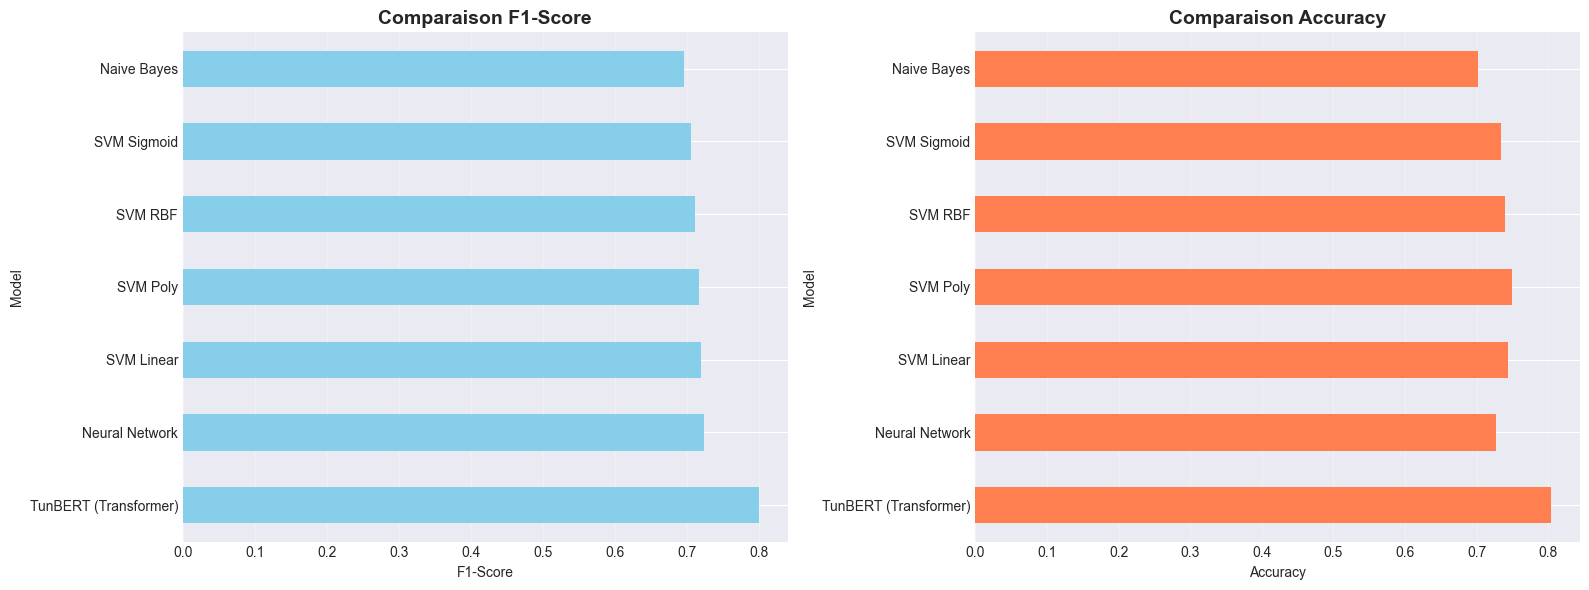


✅ Graphiques sauvegardés dans: ../models


In [77]:
# Visualisation comparative
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# F1-Score comparison
df_results_all.plot(
    x='Model', 
    y='F1-Score', 
    kind='barh', 
    ax=axes[0], 
    legend=False,
    color='skyblue'
)
axes[0].set_title('Comparaison F1-Score', fontsize=14, fontweight='bold')
axes[0].set_xlabel('F1-Score')
axes[0].grid(axis='x', alpha=0.3)

# Accuracy comparison
df_results_all.plot(
    x='Model', 
    y='Accuracy', 
    kind='barh', 
    ax=axes[1], 
    legend=False,
    color='coral'
)
axes[1].set_title('Comparaison Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Accuracy')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MODELS_DIR, 'models_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Graphiques sauvegardés dans:", MODELS_DIR)

## 6. 📋 Résumé et Export des Résultats

In [78]:
# Sauvegarder le tableau comparatif
df_results_all.to_csv(os.path.join(MODELS_DIR, 'models_comparison.csv'), index=False)
print("✅ Tableau comparatif sauvegardé: models_comparison.csv")

# Résumé final
print("\n" + "="*80)
print("📋 RÉSUMÉ FINAL")
print("="*80)
print(f"\n✅ Modèles entraînés: {len(results_all)}")
print(f"   • ML Classiques: {len(models)}")
print(f"   • Transformers: 1 (TunBERT)")
print(f"\n🏆 Meilleur modèle: {best_overall['Model']}")
print(f"   • F1-Score: {best_overall['F1-Score']:.4f}")
print(f"   • Accuracy: {best_overall['Accuracy']:.4f}")
print(f"   • Precision: {best_overall['Precision']:.4f}")
print(f"   • Recall: {best_overall['Recall']:.4f}")
print(f"\n📁 Tous les modèles sauvegardés dans: {MODELS_DIR}")
print(f"📊 Artefacts créés:")
print(f"   • Modèles ML: 6 fichiers .pkl")
print(f"   • TunBERT: dossier tunbert_final_model/")
print(f"   • Comparaison: models_comparison.csv + .png")
print("\n🎯 Modélisation terminée avec succès!")
print("="*80)

✅ Tableau comparatif sauvegardé: models_comparison.csv

📋 RÉSUMÉ FINAL

✅ Modèles entraînés: 7
   • ML Classiques: 6
   • Transformers: 1 (TunBERT)

🏆 Meilleur modèle: TunBERT (Transformer)
   • F1-Score: 0.8000
   • Accuracy: 0.8043
   • Precision: 0.7953
   • Recall: 0.8048

📁 Tous les modèles sauvegardés dans: ../models
📊 Artefacts créés:
   • Modèles ML: 6 fichiers .pkl
   • TunBERT: dossier tunbert_final_model/
   • Comparaison: models_comparison.csv + .png

🎯 Modélisation terminée avec succès!
